# Подключение необходимых библиотек

In [11]:

import copy
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from tqdm import tqdm
from torchvision import datasets, models, transforms
from torch.nn import functional as F
import torchinfo
from torchmetrics.classification import F1Score, Recall, Precision


# Считывание данных

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
num_epochs = 15
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# Аугментация данных
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

# data_transforms = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         normalize
#     ])
data = datasets.ImageFolder(root='./simpsons_dataset', transform=data_transforms['train'])
data_test = datasets.ImageFolder(root='./kaggle_simpson_testset', transform=data_transforms['test'])
generator = torch.Generator().manual_seed(42)
data_train, data_valid = torch.utils.data.random_split(data, [0.9, 0.1], generator=generator)
data_image = {
    'train':
        data_train,
    'validation':
        data_valid,
    'test':
        data_test
}

classes_image = {
    'train':
        list(data.class_to_idx.keys()),
    'test':
        list(data_test.class_to_idx.keys())
}

loaders_image = {
    'train':
        torch.utils.data.DataLoader(data_image['train'], batch_size=batch_size, shuffle=True),
    'validation':
        torch.utils.data.DataLoader(data_image['validation'], batch_size=batch_size, shuffle=True),
    'test':
        torch.utils.data.DataLoader(data_image['test'], batch_size=batch_size, shuffle=True)
}

# Визуализация картинок и их ключей

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


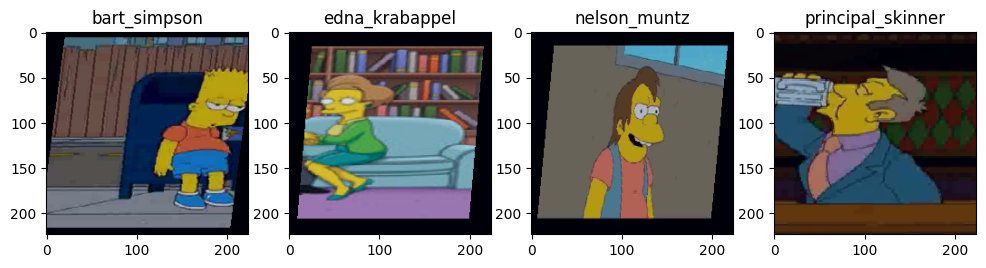

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


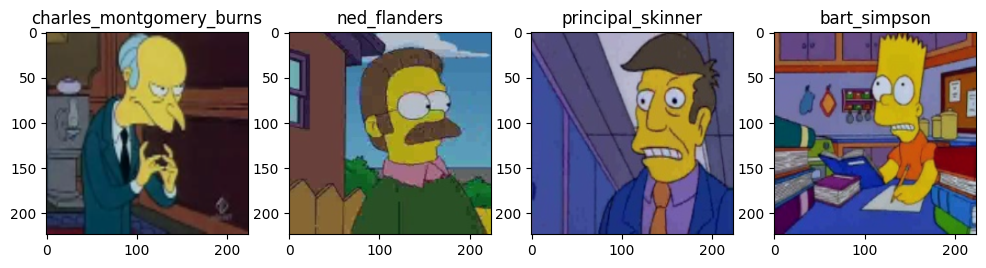

In [13]:

def image_shower(images, labels, phase, n=4):

    fig, axes = plt.subplots(1, 4)
    fig.set_figwidth(12) 
    fig.set_figheight(6)
    for i, image in enumerate(images[:n]):
        image = image * 0.2 + 0.4
        print(image.size())
        axes[i].imshow(image.numpy().transpose((1, 2, 0)).squeeze())
        axes[i].set_title(classes_image[phase][labels[i]])

    plt.show()
    

images, labels = next(iter(loaders_image['train']))
image_shower( images, labels, 'train')
images, labels = next(iter(loaders_image['test']))
image_shower( images, labels, 'test')

# Модель

In [14]:
# Добавляем предобученную модель
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Преобразуем последние слои через полносвязные так, чтобы на выход получить нужное количество классов(42) 
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 42))

model.to(device)
# Устанавливаем функцию потерь
criterion = nn.CrossEntropyLoss()
# Объявляем оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr =0.001, momentum = 0.9)  
print(torchinfo.summary(model, input_size = (batch_size, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 42]                  --
├─Conv2d: 1-1                            [64, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        (128)
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [64, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]   

# Обучение

In [15]:
model.load_state_dict(torch.load('./weights1.h5'))
train_losses = []
valid_losses = []
train_acc = []
valid_acc = []
def train_model(model, criterion, optimizer):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'validation']:
            if phase == 'train':
            # Переключаем модель в режим обучения
                model.train()
            else:
            # Переключаем модлеь в режим оценки
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loaders_image[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Делаем проход (forward pass).
                # Состояние модели `train` обеспечивает сохранение промежуточных результатов вычислений.
                # Эти сохраненные значения будут использованы ниже для вычисления градиента функции потерь.
                outputs = model(inputs)
                # Вычисляем функцию потерь на основе предсказания модели.
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()  # Удаляем накопленные ранее градиенты.
                    loss.backward() # Вычисляем градиент: направление, в котором функция потерь возрастает максимально быстро.
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() # Накапливаем статистику.
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_image[phase])
            epoch_acc = running_corrects.double() / len(data_image[phase])
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_losses.append(epoch_loss)
                valid_acc.append(epoch_acc)
                if best_acc < epoch_acc: 
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    model.load_state_dict(best_model_wts)
    return model

train_model(model, criterion, optimizer)
torch.save(model.state_dict(), './weights1.h5') # Сохранить веса, полученные после обучения



Epoch 1/15
----------
train loss: 0.0133, acc: 0.7705
validation loss: 0.0143, acc: 0.7573
Epoch 2/15
----------
train loss: 0.0132, acc: 0.7713
validation loss: 0.0144, acc: 0.7625
Epoch 3/15
----------
train loss: 0.0130, acc: 0.7723
validation loss: 0.0140, acc: 0.7711
Epoch 4/15
----------
train loss: 0.0130, acc: 0.7730
validation loss: 0.0139, acc: 0.7688
Epoch 5/15
----------
train loss: 0.0129, acc: 0.7769
validation loss: 0.0138, acc: 0.7645
Epoch 6/15
----------
train loss: 0.0127, acc: 0.7764
validation loss: 0.0141, acc: 0.7630
Epoch 7/15
----------
train loss: 0.0125, acc: 0.7807
validation loss: 0.0140, acc: 0.7582
Epoch 8/15
----------
train loss: 0.0125, acc: 0.7804
validation loss: 0.0142, acc: 0.7587
Epoch 9/15
----------
train loss: 0.0122, acc: 0.7882
validation loss: 0.0137, acc: 0.7688
Epoch 10/15
----------
train loss: 0.0123, acc: 0.7826
validation loss: 0.0139, acc: 0.7649
Epoch 11/15
----------
train loss: 0.0121, acc: 0.7867
validation loss: 0.0135, acc: 0.76

# График Loss

Text(0, 0.5, 'Loss')

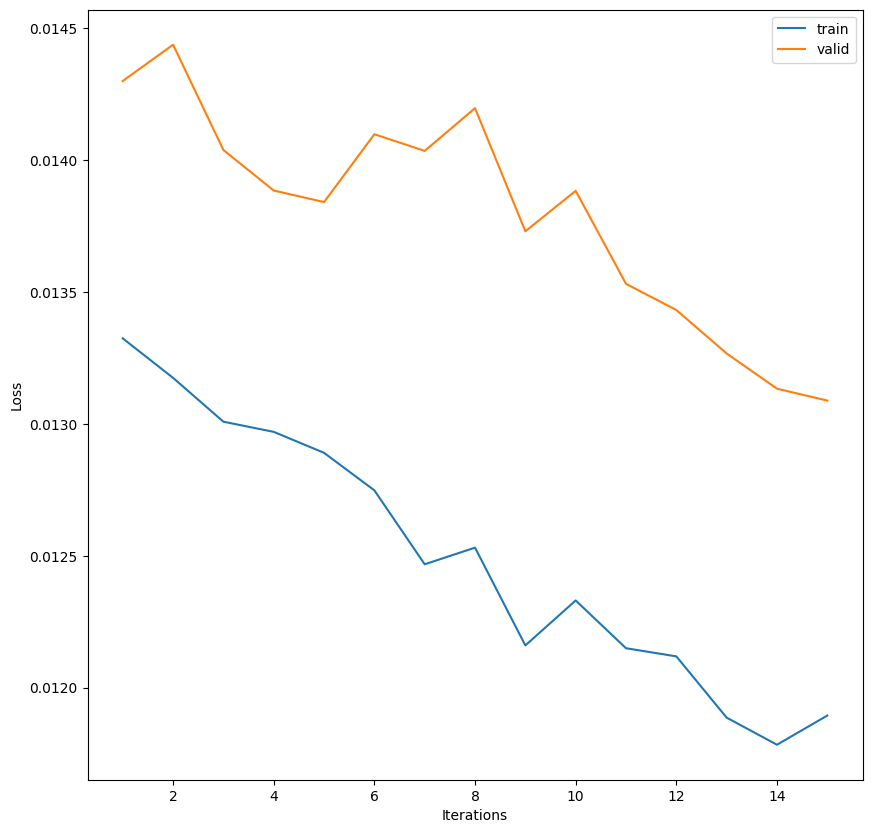

In [16]:
fig = plt.figure(figsize=(10, 10))

plt.plot(range(1, num_epochs + 1), train_losses, label='train')
plt.plot(range(1, num_epochs + 1), valid_losses, label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')


# График accuracy

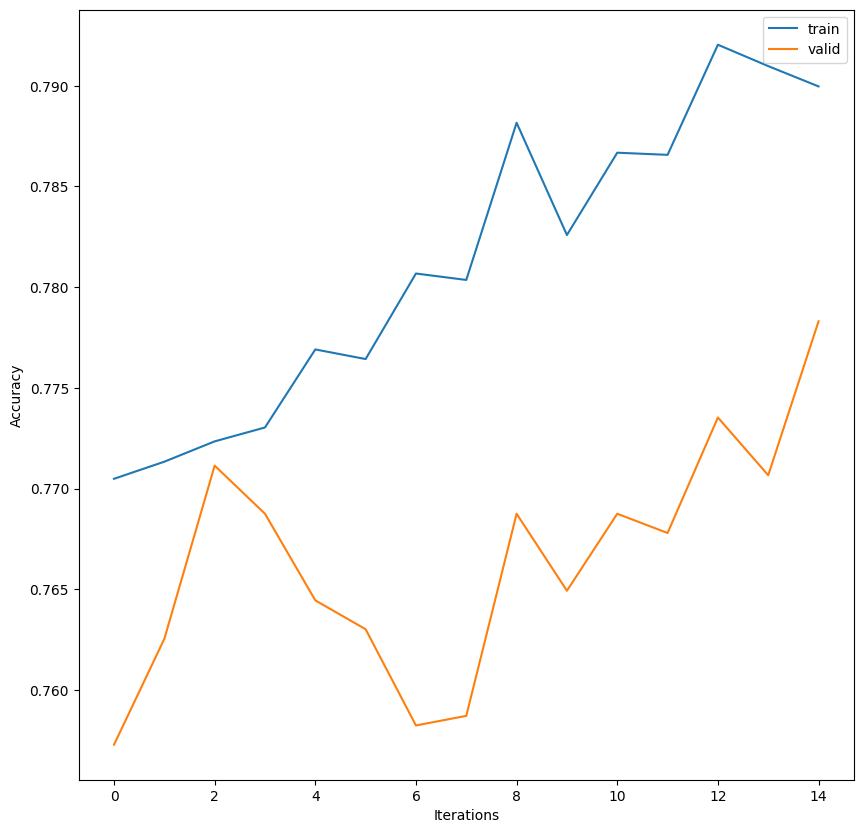

In [17]:
fig = plt.figure(figsize=(10, 10))

plt.plot(list(map(lambda tens: tens.cpu(), train_acc)), label='train')
plt.plot(list(map(lambda tens: tens.cpu(), valid_acc)), label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.show()

# Точность

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


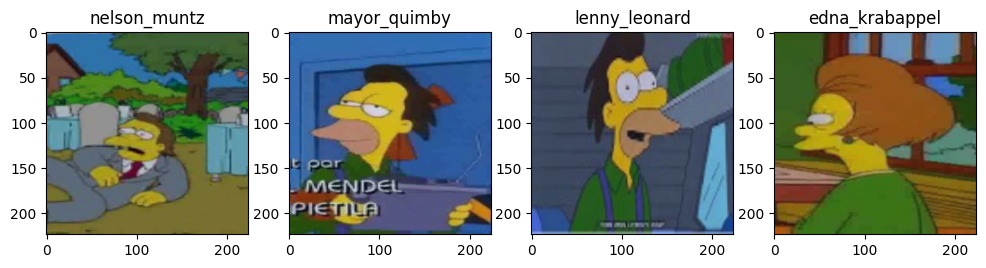

F1-score of the network on the 990 validation images: 82.3682 %


In [18]:
# Объявляем метрику для подсчета итоговой точности модели
f1_score = F1Score(task = "multiclass", num_classes = 42, average='weighted')
with torch.no_grad():

    total = 0
    all_labels = []
    all_predicts = []

    for i, (images, labels) in enumerate(loaders_image['test']):
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)

        if not i:
            image_shower(images.cpu(), predicted.cpu(),'train')

        for a, res in enumerate(predicted):
            if classes_image['train'][res] == classes_image['test'][labels[a]]:
               predicted[a] = labels[a]

        all_labels = np.concatenate((all_labels, labels.cpu()), axis = 0)
        all_predicts = np.concatenate((all_predicts, predicted.cpu()), axis = 0)

        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print('F1-score of the network on the {} validation images: {:.4f} %'.format(total, 100 * f1_score(torch.tensor(all_predicts), torch.tensor(all_labels))))
